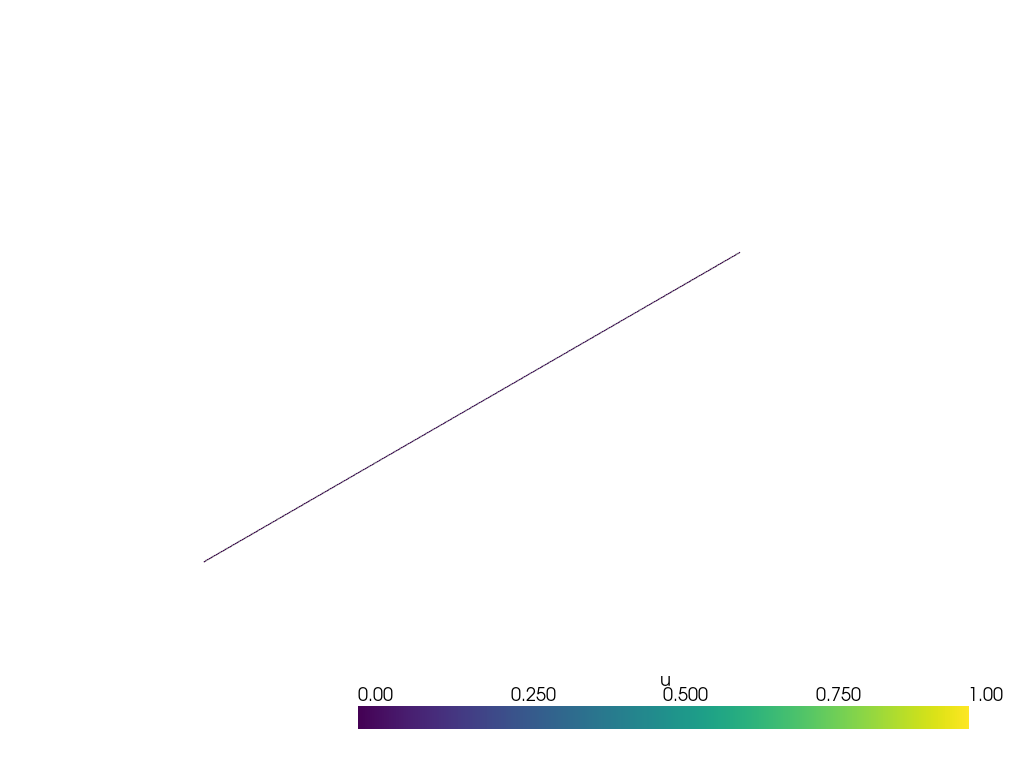

In [ ]:
# heat_1d_dolfinx.py
#
# Solves the heat equation on a 1D rod x∈[0,1]:
#   ∂u/∂t = ∂²u/∂x² + f,   u(0)=u(1)=0,
# with f = 0 and u(t=0,x) = sin(pi x),
# using implicit Euler time stepping (dt=0.1) for 5 steps.
# Plots initial and subsequent solutions with PyVista.

from mpi4py import MPI
import numpy as np
import ufl
from dolfinx import mesh, fem, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import dx, grad, inner
from petsc4py.PETSc import ScalarType

# -----------------------
# Discretization settings
# -----------------------
n_elements = 32
time_step_length = 0.1
n_time_steps = 5

# ---------------
# Mesh and space
# ---------------
msh = mesh.create_unit_interval(MPI.COMM_WORLD, n_elements)
V = fem.functionspace(msh, ("Lagrange", 1))

# -----------------------
# Homogeneous Dirichlet BC on x=0 and x=1
# -----------------------
fdim = msh.topology.dim - 1

def on_boundary_ends(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0)

facets = mesh.locate_entities_boundary(msh, fdim, on_boundary_ends)
dofs = fem.locate_dofs_topological(V=V, entity_dim=fdim, entities=facets)
bc = fem.dirichletbc(ScalarType(0.0), dofs, V)

# -----------------------
# Initial condition u0(x) = sin(pi*x)
# -----------------------
u_old = fem.Function(V)
u_old.interpolate(lambda x: np.sin(np.pi * x[0]))

# -----------------------
# Forcing term f = 0
# -----------------------
heat_source = fem.Constant(msh, ScalarType(0.0))

# -----------------------
# Variational problem (implicit Euler)
# a(u, v) = (u*v + dt * ∇u·∇v) dx
# L(v)    = (u_old*v + dt * f*v) dx
# -----------------------
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = inner(u, v) * dx + time_step_length * inner(grad(u), grad(v)) * dx
L = inner(u_old, v) * dx + time_step_length * inner(heat_source, v) * dx

# Function to hold the solution at each step
u_solution = fem.Function(V)

# Assemble/solve as a linear problem (matrix structure constant in time)
problem = LinearProblem(
    a, L, bcs=[bc],
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
)

# -----------------------
# Visualization (PyVista)
# -----------------------
# We’ll add the initial state and each time step to the same PyVista scene.
# Only rank 0 drives visualization.
try:
    import pyvista
    cells, types, X = plot.vtk_mesh(V)
    # Helper to build a fresh grid for a given function (so we can overlay curves)
    def make_grid_from(u_fn):
        grid = pyvista.UnstructuredGrid(cells, types, X)
        grid.point_data["u"] = u_fn.x.array.real.copy()
        grid.set_active_scalars("u")
        return grid

    p = None
    if msh.comm.rank == 0:
        p = pyvista.Plotter()
        # Initial condition
        grid0 = make_grid_from(u_old)
        p.add_mesh(grid0, show_edges=True)
        # p.add_mesh(grid0.warp_by_scalar())  # 3D warp to see the profile

except ModuleNotFoundError:
    p = None

# -----------------------
# Time stepping
# -----------------------
time_current = 0.0
for _ in range(n_time_steps):
    time_current += time_step_length
    # Solve (A constant) for current RHS
    uh = problem.solve()
    u_solution.x.array[:] = uh.x.array  # ensure u_solution holds the result
    # Update for next step
    u_old.x.array[:] = u_solution.x.array

    # Add this timestep to the plot
    if p is not None and msh.comm.rank == 0:
        gridk = make_grid_from(u_solution)
        p.add_mesh(gridk, show_edges=True)
        p.add_mesh(gridk.warp_by_scalar())

# Show or screenshot (rank 0 only)
if p is not None and msh.comm.rank == 0:
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        p.screenshot("heat_1d_timeseries.png")
    else:
        p.show()
